In [3]:
import numpy as np 
import keras  
from keras.datasets import mnist 
from keras.models import Model ,Sequential
from keras.layers import Dense, Input
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten 
from keras import backend as k 
from scipy import ndimage
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
def rgb2gray(data):
    new_data = np.zeros((data.shape[0],data.shape[1],data.shape[2]))
    for i in range(len(data)):
        new_data[i] = np.dot(data[i][...,:3], [0.2989, 0.5870, 0.1140])
    return new_data

In [3]:
train_data = np.load("traffic-signs/train.p")['features']
test_data  = np.load("traffic-signs/test.p")['features']
print(test_data.shape)
print(train_data.shape)
train_data = rgb2gray(train_data)
test_data  = rgb2gray(test_data)

# (x_train, y_train), (x_test, y_test) = mnist.load_data() 
x_train, y_train, x_test, y_test = train_data ,  np.load("traffic-signs/train.p")['labels'] , test_data ,np.load("traffic-signs/test.p")['labels']

(12630, 32, 32, 3)
(34799, 32, 32, 3)


In [4]:
print (x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(34799, 32, 32) (34799,) (12630, 32, 32) (12630,)


In [5]:
new_x_train   = np.zeros((train_data.shape[0],48,48))
rotated_train = np.zeros((train_data.shape[0],48,48))
new_x_test    = np.zeros((test_data.shape[0],48,48))
rotated_test  = np.zeros((test_data.shape[0],48,48))
mixed_train   = np.zeros((train_data.shape[0],48,48))

In [6]:

for i in range(len(x_train)):
    original_img   = x_train[i]
    rotation_angle = np.random.randint(360)
    rotated_image  = ndimage.rotate(original_img, rotation_angle)
    tr = (48-rotated_image.shape[0])//2
    dr = (48-rotated_image.shape[1]) - tr
    lc = (48-rotated_image.shape[0])//2
    rc = (48-rotated_image.shape[1]) - lc
#     print (tr,dr,lc,rc)
    new_x_train[i] = np.pad(original_img, ( (8,8),(8,8) ) ,mode='constant',constant_values=0)
    rotated_train[i] = np.pad(rotated_image, ( (tr,dr),(lc,rc) ) ,mode='constant',constant_values=0)
    
    # plt.imshow(original_img)
    # plt.imshow(rotated_image)
for i in range(len(x_test)):
    rotation_angle = np.random.randint(360)
    rotated_image = ndimage.rotate(x_test[i], rotation_angle)
    tr = (48-rotated_image.shape[0])//2
    dr = (48-rotated_image.shape[1]) - tr
    lc = (48-rotated_image.shape[0])//2
    rc = (48-rotated_image.shape[1]) - lc
    
    rotated_test[i]=np.pad(rotated_image, ( (tr,dr),(lc,rc) ) ,mode='constant',constant_values=0)
    
    new_x_test[i]=np.pad(x_test[i], ( (8,8),(8,8) ) ,mode='constant',constant_values=0)


In [7]:
img_rows, img_cols=48, 48
new_x_train = new_x_train.reshape(new_x_train.shape[0], img_rows, img_cols, 1) 
rotated_train = rotated_train.reshape(rotated_train.shape[0], img_rows, img_cols, 1)
new_x_test = new_x_test.reshape(new_x_test.shape[0], img_rows, img_cols, 1) 
rotated_test = rotated_test.reshape(rotated_test.shape[0], img_rows, img_cols, 1) 
inpx = (img_rows, img_cols, 1) 

y_train = keras.utils.to_categorical(y_train,43)    #One Hot Encode
y_test = keras.utils.to_categorical(y_test,43)      #One Hot Encode


x_train = x_train.astype('float32') 
rotated_train = rotated_train.astype('float32') 
new_x_train = new_x_train.astype('float32') 
x_test = x_test.astype('float32') 
new_x_test = new_x_test.astype('float32') 
rotated_test = rotated_test.astype('float32') 


# x_train /= 255
# new_x_train /= 255
# rotated_train /= 255
# x_test /= 255
# new_x_test /= 255
# rotated_test /= 255

inpx = Input(shape=inpx) 
layer1 = Conv2D(32, kernel_size=(3, 3), activation='relu')(inpx) 
layer2 = Conv2D(64, (3, 3), activation='relu')(layer1) 
layer3 = MaxPooling2D(pool_size=(3, 3))(layer2) 
layer4 = Dropout(0.5)(layer3) 
layer5 = Flatten()(layer4) 
layer6 = Dense(250, activation='sigmoid')(layer5) 
layer7 = Dense(43, activation='softmax')(layer6) 
# model = Model([inpx], layer7) 
# model.compile(optimizer=keras.optimizers.Adadelta(), loss=keras.losses.categorical_crossentropy, metrics=['accuracy']) 


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [8]:
mixed_test = np.concatenate((new_x_test, rotated_test), axis=0)
mixed_y_test = np.concatenate((y_test, y_test), axis=0)

In [9]:
scores=[]
k=0;
while k<=100:
    for i in range(len(x_train)):
        percent = len(x_train)*k//100
        if i<percent:
            new_x_train[i] = rotated_train[i]
        else:
            break
    model = Model([inpx], layer7) 
    model.compile(optimizer=keras.optimizers.Adadelta(), loss=keras.losses.categorical_crossentropy, metrics=['accuracy']) 
    model.fit(new_x_train, y_train, epochs=2, batch_size=128)
    score = model.evaluate(rotated_test, y_test, verbose=0)
    scores.append(score)
    print('Rotated data percentage', k)
    print('loss=', score[0]) 
    print('accuracy=', score[1]) 
    k+=20

Instructions for updating:
Use tf.cast instead.
Epoch 1/3
34799/34799 [==============================] - 167s 5ms/step - loss: 3.5003 - acc: 0.0566
Epoch 2/3
34799/34799 [==============================] - 187s 5ms/step - loss: 3.4926 - acc: 0.0561
Epoch 3/3
34799/34799 [==============================] - 189s 5ms/step - loss: 3.4855 - acc: 0.0567
Rotated data percentage 0
loss= 3.4751701099761214
accuracy= 0.05700712589545563
Epoch 1/3
34799/34799 [==============================] - 189s 5ms/step - loss: 3.4515 - acc: 0.0772
Epoch 2/3
34799/34799 [==============================] - 188s 5ms/step - loss: 2.0043 - acc: 0.4925
Epoch 3/3
34799/34799 [==============================] - 188s 5ms/step - loss: 0.3503 - acc: 0.9222
Rotated data percentage 10
loss= 6.133233713858296
accuracy= 0.16825019794848828
Epoch 1/3
34799/34799 [==============================] - 188s 5ms/step - loss: 0.3005 - acc: 0.9211
Epoch 2/3
34799/34799 [==============================] - 187s 5ms/step - loss: 0.1661 - ac

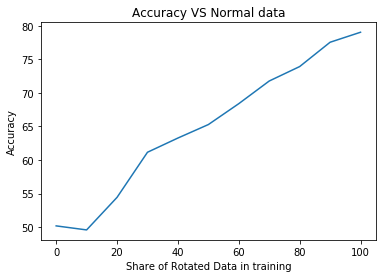

In [11]:
scores = [(3.4751701099761214,0.05700712589545563),(0.5467910362958908,0.16825019794848828),(0.33211031255126,0.22549485353043602),(0.23140600017607213,0.32169437847341326),(0.1824785115376115,0.39722882027863887),(0.1563132534109056,0.5121931908107993),(0.14079290256612004,0.5622327791209837),(0.1285845530539751,0.6443388756880757),(0.11929636264964938,0.7095011876767718),(0.11176297247093171,0.7653998416751883),(0.10753180085103958,0.8329374505240863)]
# plt.plot([scores[i][1] for i in range(11)],[i*10 for i in range(11)])
# plt.plot([scores[i][0] for i in range(11)],[i*10 for i in range(11)])
# acc = [0.5017814726840855,0.4957719714987967,0.544299287413286,0.61153602533886,0.6327315914489311,0.652810768007949,0.6839746634948848,0.7177355502676794,0.7392715756136184,0.7755186064830396,0.7904275534441805]
plt.plot([i*10 for i in range(11)],[acc[i]*100 for i in range(11)])
plt.ylabel("Accuracy")
plt.xlabel("Share of Rotated Data in training")
plt.title("Accuracy VS Normal data")
plt.show()

In [ ]:
plt.plot([scores[i][0] for i in range(11)],[i*10 for i in range(11)])
plt.ylabel("Loss")
plt.xlabel("Share of Rotated Data in training")
plt.title("Loss VS Mixed Rotated data")
plt.show()

In [ ]:
scores